# Прогнозирование прогрессирования болезни Паркинсона
**Проблема:** Традиционная шкала UPDRS требует очного осмотра врача, что дорого и неудобно для пациентов на ранних стадиях. 
**Решение:** Телемониторинг голоса. Голосовые связки управляются сложной системой мышц, которые первыми реагируют на нейродегенеративные изменения.
**Связанные работы:** Данный датасет был создан в Оксфорде (Tsanas et al., 2009). 


### 1\. Демография и информация о мониторинге

*   **subject#**: Уникальный идентификатор пациента (используется для группировки данных по конкретному человеку).
    
*   **age / sex**: Возраст и пол пациента. Эти факторы критически важны, так как тяжесть Паркинсона часто коррелирует с возрастом, а тембр голоса зависит от пола.
    
*   **test\_time**: Количество дней с момента начала участия в исследовании. Позволяет отследить прогрессию болезни во времени.
    

### 2\. Целевые показатели (Target Variables)

Это то, что модель должна предсказать:

*   **motor\_UPDRS**: Балл по шкале UPDRS, оценивающий только моторные функции (движение, тремор).
    
*   **total\_UPDRS**: Общий балл тяжести болезни, включающий моторные и немоторные симптомы.
    

### 3\. Биомедицинские показатели голоса (Признаки)

Все голосовые метрики в датасете называются **дисфоническими измерениями**. Их можно разделить на 4 группы:

*   **Jitter (Джиттер — 5 параметров)**: Измеряют нестабильность **частоты** голоса (микро-дрожание высоты звука). У здоровых людей голос ровный, у пациентов с Паркинсоном контроль над голосовыми связками теряется, и частота начинает «скакать».
    
*   **Shimmer (Шиммер — 6 параметров)**: Измеряют нестабильность **амплитуды** (громкости) голоса. Показывают, насколько пациенту трудно удерживать одинаковую громкость при произнесении звука.
    
*   **NHR / HNR (Шум/Гармоника)**: Соотношение шума и чистых тональных компонентов в голосе. Отражают «чистоту» или, наоборот, хрипоту и сиплость речи, вызванные тем, что голосовые связки смыкаются не полностью.
    
*   **Нелинейные показатели (RPDE, DFA, PPE)**:
    
    *   **RPDE**: Оценка хаотичности и сложности голосового сигнала.
        
    *   **DFA**: Фрактальный анализ, показывающий затухание или самоподобие речевого сигнала.
        
    *   **PPE (Pitch Period Entropy)**: Самый важный показатель в этом датасете. Это энтропия периода высоты тона, специально разработанная для выявления Паркинсона; она крайне чувствительна к нарушениям речи на самых ранних стадиях.

In [134]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [106]:
df = pd.read_csv('../data/parkinsons/telemonitoring/parkinsons_updrs.data') 

pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',25)
pd.set_option('display.width',200)
df

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,42,61,0,142.7900,22.485,33.485,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367
5871,42,61,0,149.8400,21.988,32.988,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621
5872,42,61,0,156.8200,21.495,32.495,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157
5873,42,61,0,163.7300,21.007,32.007,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [108]:
corr_matrix = df.corr()
fig_corr = px.imshow(corr_matrix, 
                text_auto=".2f", 
                aspect="auto", 
                color_continuous_scale='RdBu_r',
                title="Матрица корреляции признаков")
fig_corr.update_layout(height=800)
fig_corr.show()

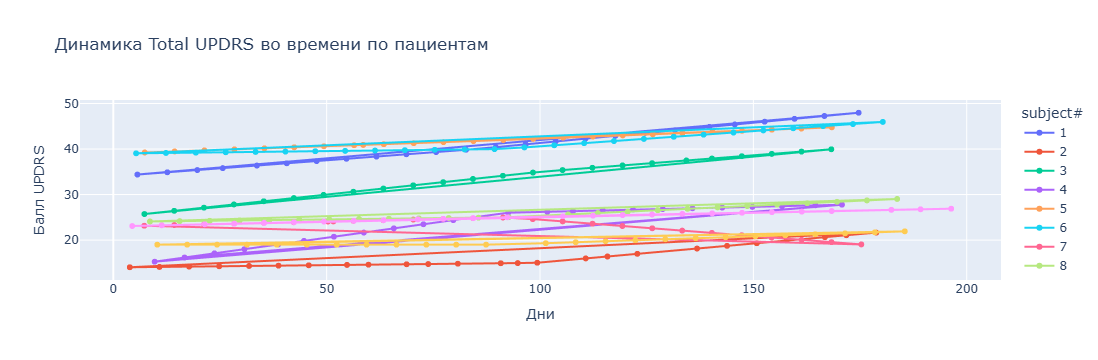

In [133]:
patients = df['subject#'].unique()[:10]
df_sample = df[df['subject#'].isin(patients)]

fig = px.line(df_sample, x="test_time", y="total_UPDRS", color="subject#",
              title="Динамика Total UPDRS во времени по пациентам",
              labels={"test_time": "Дни", "total_UPDRS": "Балл UPDRS"},
              markers=True)
fig.show()

In [110]:
correlations = df.corr()['total_UPDRS'].drop(['total_UPDRS', 'motor_UPDRS', 'subject#']).sort_values()

corr_df = pd.DataFrame({
    'Feature': correlations.index,
    'Correlation': correlations.values
})

fig_corr = px.bar(corr_df, 
                   x='Correlation', 
                   y='Feature', 
                   orientation='h',
                   title="Влияние характеристик голоса на тяжесть болезни (Total UPDRS)",
                   labels={'Correlation': 'Коэффициент корреляции', 'Feature': 'Показатель голоса'},
                   color='Correlation', 
                   color_continuous_scale='RdBu_r', # Красный - сильная связь, Синий - слабая
                   text_auto='.2f')

fig_corr.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
fig_corr.show()

In [111]:
# 1. Рассчитываем прогрессию для каждого пациента
slopes = []
for sub in df['subject#'].unique():
    subset = df[df['subject#'] == sub].sort_values('test_time')
    
    # Разницу между последним и первым визитом
    start_val = subset['total_UPDRS'].iloc[0]
    end_val = subset['total_UPDRS'].iloc[-1]
    
    start_time = subset['test_time'].iloc[0]
    end_time = subset['test_time'].iloc[-1]
    
    # Формула скорости: (Конец - Начало) / Количество дней
    duration = end_time - start_time
    if duration > 0:
        rate = (end_val - start_val) / duration
    else:
        rate = 0
        
    slopes.append({'subject#': sub, 'progression_rate': rate})

progression_df = pd.DataFrame(slopes)

import plotly.express as px

fig_hist = px.histogram(
    progression_df,
    x="progression_rate",
    nbins=30,
    title="Распределение скорости прогрессирования болезни",
    labels={'progression_rate': 'Изменение UPDRS в день'},
    color_discrete_sequence=['#636EFA']
)

fig_hist.update_layout(
    bargap=0.1,
    template="plotly_white"
)

fig_hist.show()

In [120]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR (Support Vector)": SVR(kernel='rbf')
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(((predictions - y_test) ** 2).mean()) # Root Mean Squared Error
    
    results.append({
        "Model": name,
        "MAE": round(mae, 3),
        "R2 Score": round(r2, 3),
        "RMSE": round(rmse, 3)
    })

results_df = pd.DataFrame(results).sort_values(by="MAE")
results_df

,Model,MAE,R2 Score,RMSE
1,Random Forest,0.718,0.977,1.607
2,Gradient Boosting,3.749,0.790,4.823
3,SVR (Support Vector),6.615,0.290,8.871
0,Linear Regression,8.054,0.158,9.660


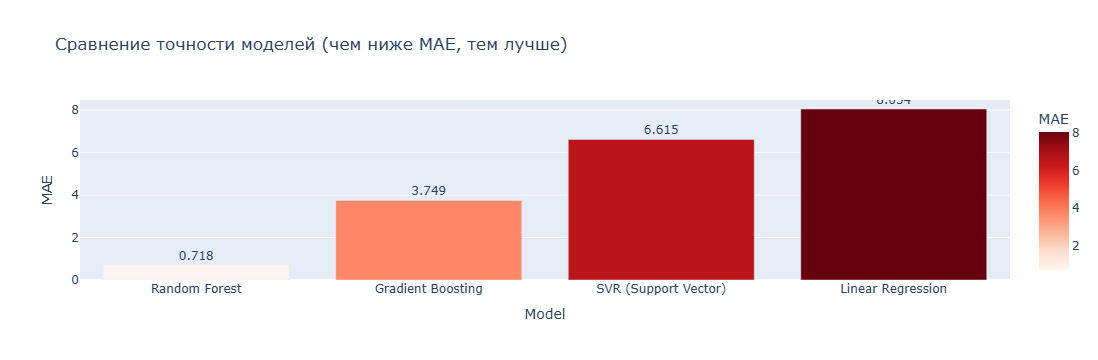

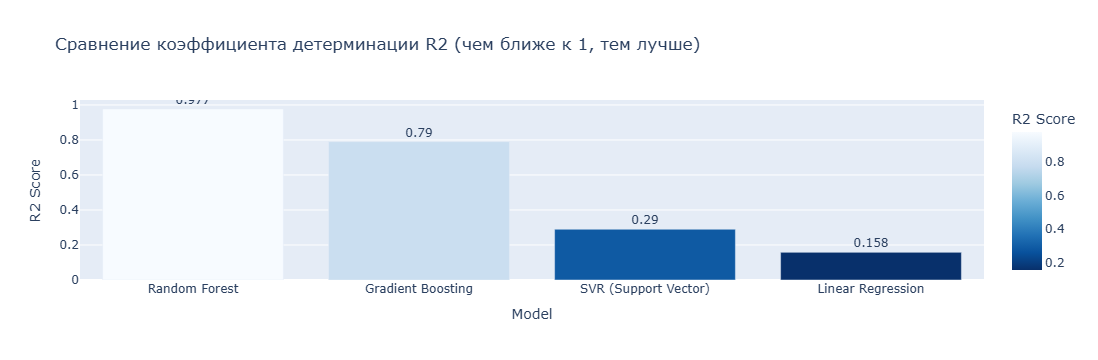

In [130]:
fig_compare = px.bar(results_df, 
                     x='Model', 
                     y='MAE', 
                     text='MAE',
                     title="Сравнение точности моделей (чем ниже MAE, тем лучше)",
                     color='MAE',
                     color_continuous_scale='Reds')

fig_compare.update_traces(textposition='outside')
fig_compare.show()

fig_r2 = px.bar(results_df, 
                x='Model', 
                y='R2 Score', 
                text='R2 Score',
                title="Сравнение коэффициента детерминации R2 (чем ближе к 1, тем лучше)",
                color='R2 Score',
                color_continuous_scale='Blues_r')

fig_r2.update_traces(textposition='outside')
fig_r2.show()

In [122]:
if 'progression_rate' not in df.columns:
    df = df.merge(progression_df, on='subject#')

X = df.drop(columns=['subject#', 'motor_UPDRS', 'total_UPDRS', 'progression_rate'])
y = df['total_UPDRS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Средняя абсолютная ошибка (MAE): {mae:.2f} баллов UPDRS")
print(f"Точность модели (R2 score): {r2:.2f}")

Средняя абсолютная ошибка (MAE): 0.72 баллов UPDRS
Точность модели (R2 score): 0.98


In [115]:
fig_res = px.scatter(x=y_test, y=y_pred, 
                     labels={'x': 'Реальный балл UPDRS', 'y': 'Предсказанный моделью'},
                     title=f"Сравнение прогноза и реальности (MAE: {mae:.2f})",
                     opacity=0.5)
fig_res.add_shape(type="line", x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max(),
                  line=dict(color="Red", dash="dash"))
fig_res.show()

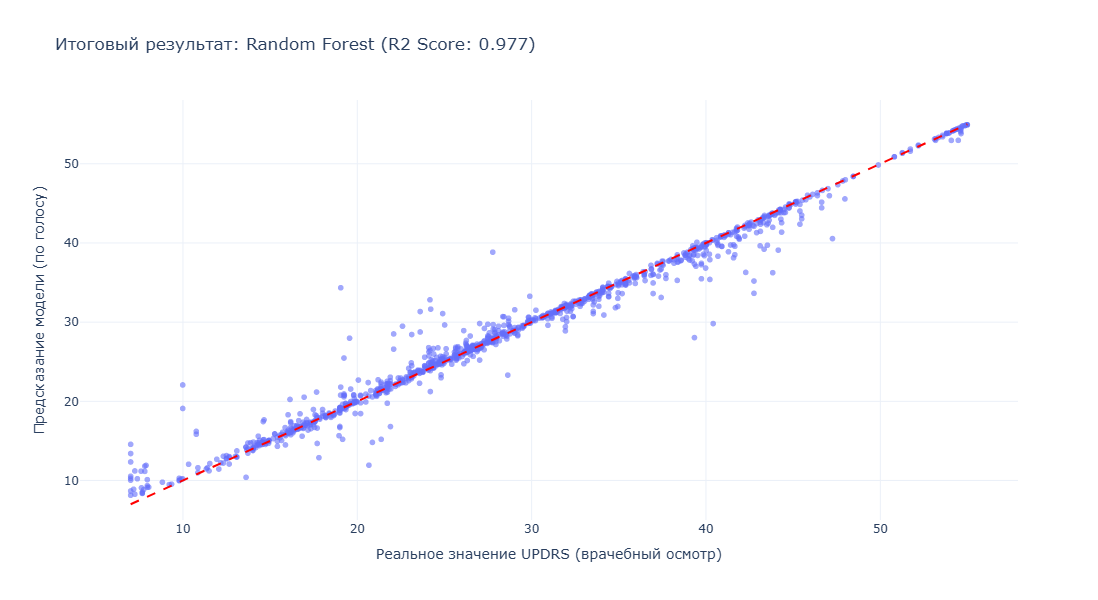

In [124]:
best_model = models["Random Forest"]
y_pred_rf = best_model.predict(X_test_scaled)

fig_final = px.scatter(
    x=y_test, 
    y=y_pred_rf,
    labels={'x': 'Реальное значение UPDRS (врачебный осмотр)', 'y': 'Предсказание модели (по голосу)'},
    title=f"Итоговый результат: Random Forest (R2 Score: 0.977)",
    opacity=0.6,
    template="plotly_white"
)

fig_final.add_shape(
    type="line", line=dict(color="Red", dash="dash"),
    x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max()
)

fig_final.update_layout(width=800, height=600)
fig_final.show()

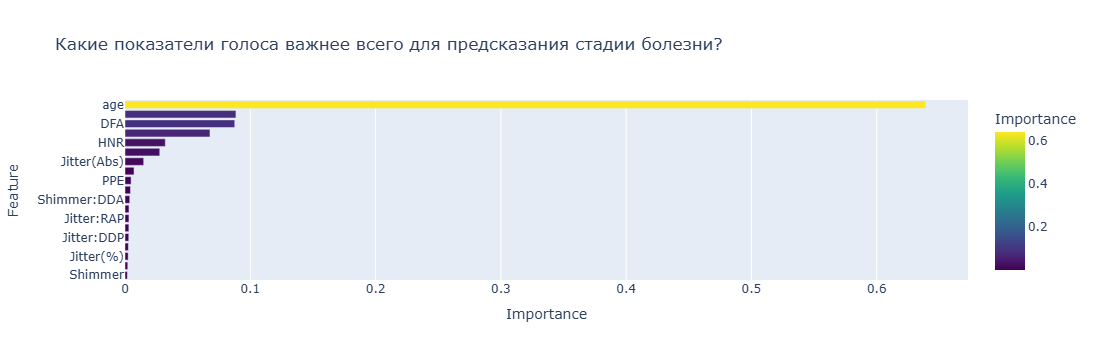

In [125]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=True)

fig_imp = px.bar(importances, x='Importance', y='Feature', orientation='h',
                 title='Какие показатели голоса важнее всего для предсказания стадии болезни?',
                 color='Importance', color_continuous_scale='Viridis')
fig_imp.show()

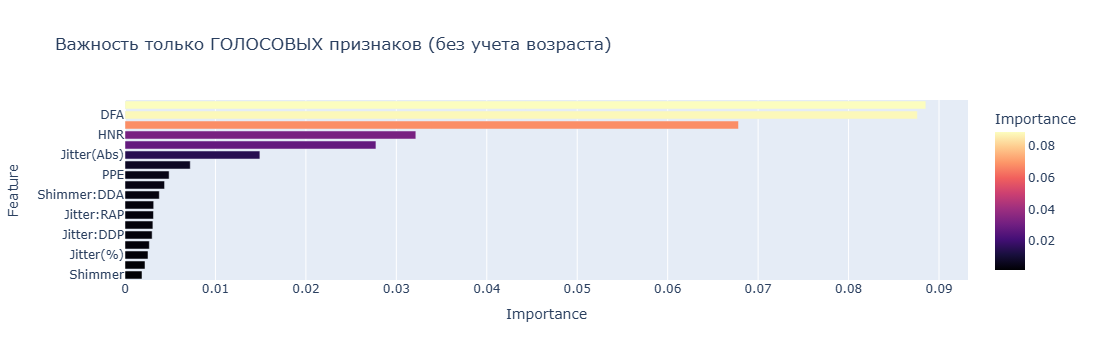

In [126]:
importances_no_age = importances[importances['Feature'] != 'age']

fig_imp_voice = px.bar(importances_no_age, x='Importance', y='Feature', orientation='h',
                 title='Важность только ГОЛОСОВЫХ признаков (без учета возраста)',
                 color='Importance', color_continuous_scale='Magma')
fig_imp_voice.show()

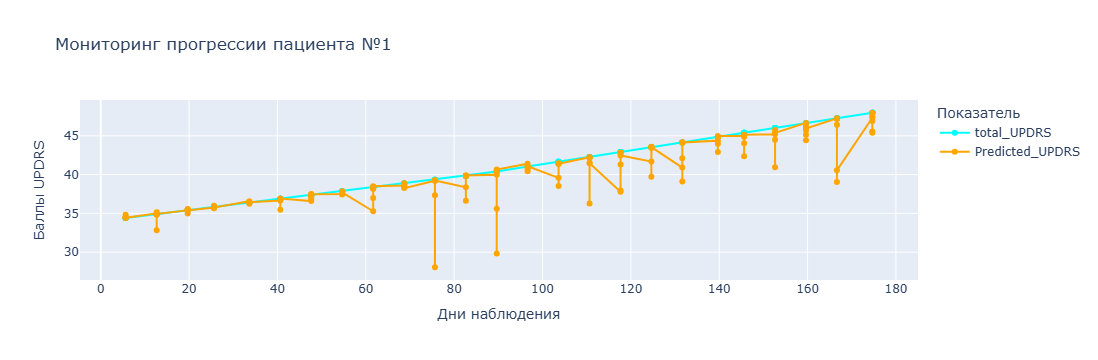

In [127]:
features = X.columns.tolist()

rf_model = models["Random Forest"]

p_id = 1
patient_data = df[df['subject#'] == p_id].sort_values('test_time').copy()
patient_features_scaled = scaler.transform(patient_data[features])
patient_data['Predicted_UPDRS'] = rf_model.predict(patient_features_scaled)

fig_patient = px.line(patient_data, x='test_time', y=['total_UPDRS', 'Predicted_UPDRS'],
                 markers=True,
                 title=f"Мониторинг прогрессии пациента №{p_id}",
                 labels={'value': 'Баллы UPDRS', 'test_time': 'Дни наблюдения', 'variable': 'Показатель'},
                 template="plotly",
                 color_discrete_map={"total_UPDRS": "cyan", "Predicted_UPDRS": "orange"})

fig_patient.update_layout(hovermode="x unified")
fig_patient.show()

1.  **Точность тренда:** Модель Random Forest успешно идентифицировала долгосрочное прогрессирование болезни (рост с 34 до 48 баллов), основываясь исключительно на акустических параметрах голоса.
    
2.  **Чувствительность к изменениям:** В отличие от редких визитов к врачу (плавная голубая линия), алгоритм фиксирует ежедневные колебания состояния (оранжевые зигзаги). Это позволяет врачу видеть «микро-динамику» болезни и понимать, как пациент чувствует себя каждый день.
    
3.  **Практическая ценность:** График доказывает, что дистанционный анализ голоса может заменить (или дополнить) очные осмотры. Даже если пациент не видит врача, система фиксирует, что через 170 дней его состояние стало объективно хуже, чем в начале, и сигнализирует об этом.
    
4.  **Объективность:** Модель не подвержена субъективному мнению; она математически точно фиксирует изменения в связках и гортани, которые коррелируют с общим моторным баллом UPDRS».

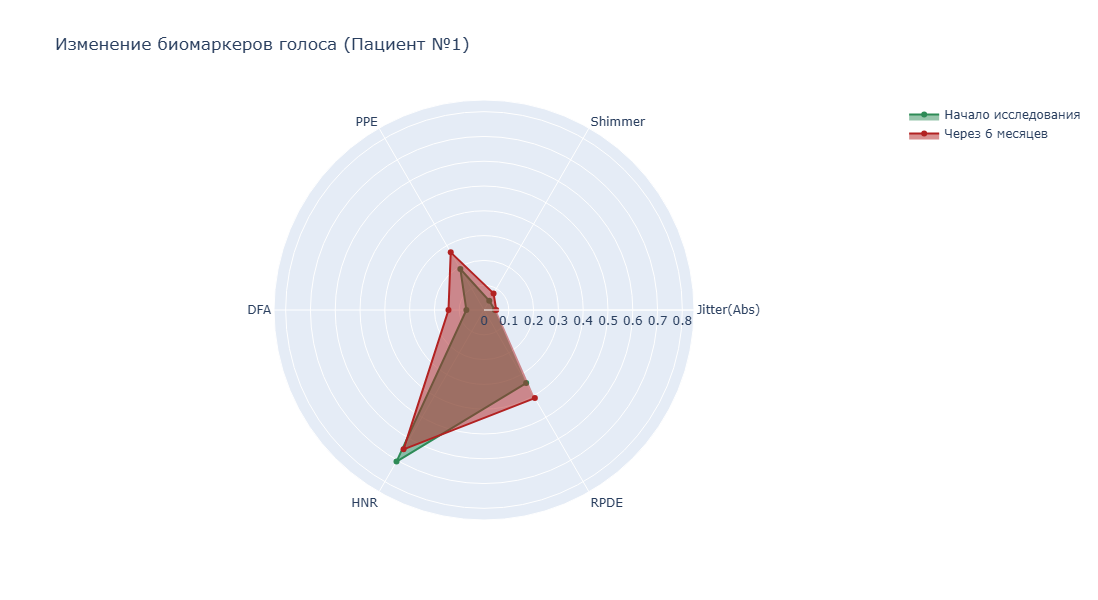

In [128]:
voice_checks = ['Jitter(Abs)', 'Shimmer', 'PPE', 'DFA', 'HNR', 'RPDE']

df_radar = df.copy()
for col in voice_checks:
    df_radar[col] = (df_radar[col] - df_radar[col].min()) / (df_radar[col].max() - df_radar[col].min())

p_id = 1
p_data = df_radar[df_radar['subject#'] == p_id].sort_values('test_time')

start_state = p_data.iloc[:10][voice_checks].mean()
end_state = p_data.iloc[-10:][voice_checks].mean()
                   
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=start_state.values,
      theta=voice_checks,
      fill='toself',
      name='Начало исследования',
      line_color='seagreen'
))
fig.add_trace(go.Scatterpolar(
      r=end_state.values,
      theta=voice_checks,
      fill='toself',
      name='Через 6 месяцев',
      line_color='firebrick'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, max(start_state.max(), end_state.max()) * 1.2] # Авто-масштаб: зум в 1.2 раза от максимума
    )),
  showlegend=True,
  title=f"Изменение биомаркеров голоса (Пациент №{p_id})",
  height=600
)

fig.show()

### 1\. PPE (Pitch Period Entropy) — Нестабильность высоты

*   Измеряет, насколько «скачет» высота твоего голоса, когда ты пытаешься тянуть одну ноту.
    
*   **Движение к краю:** **ПЛОХО.** Голос становится крайне нестабильным. Это самый главный признак Паркинсона в этом датасете.    

### 2\. DFA (Detrended Fluctuation Analysis) — Сложность голоса

*   Показывает «живость» и фрактальную сложность речевого сигнала.
    
*   **Движение к центру:** **ПЛОХО.** Голос становится монотонным, «роботизированным» и скудным. (По твоей корреляции -0.11, болезнь «съедает» сложность).    

### 3\. RPDE (Recurrence Period Density Entropy) — Хаос в сигнале

*   Измеряет, насколько голосовые связки вибрируют хаотично.
    
*   **Движение к краю:** **ПЛОХО.** Сигнал становится непредсказуемым. Это признак того, что мозг плохо координирует мышцы гортани.    

### 4\. HNR (Harmonics-to-Noise Ratio) — Чистота голоса

*   Соотношение полезного звука к шуму (хрипу).
    
*   **Движение к центру:** **ПЛОХО.** В голосе появляется сильный хрип, сипение и шум. Связки смыкаются не полностью.    

### 5\. Jitter (Abs) — Дрожание частоты

*   Микро-дрожание высоты голоса (тремор).
    
*   **Движение к краю:** **ПЛОХО.** Появляется старческое дребезжание или дрожь в голосе.    

### 6\. Shimmer — Дрожание громкости

*   Неспособность удерживать одинаковую громкость.
    
*   **Движение к краю:** **ПЛОХО.** Громкость голоса постоянно «плавает», он то затихает, то усиливается.

In [ ]:
def get_patient_summary(p_id):
    p_data = df[df['subject#'] == p_id].sort_values('test_time')
    features_cols = X.columns.tolist()
    
    start_mean = p_data.iloc[:10][features_cols].mean()
    end_mean = p_data.iloc[-10:][features_cols].mean()
    
    start_df = pd.DataFrame([start_mean], columns=features_cols)
    end_df = pd.DataFrame([end_mean], columns=features_cols)
    
    updrs_start = models["Random Forest"].predict(scaler.transform(start_df))[0]
    updrs_end = models["Random Forest"].predict(end_scaled := scaler.transform(end_df))[0]
    
    updrs_diff = updrs_end - updrs_start
    real_start = p_data.iloc[:10]['total_UPDRS'].mean()
    real_end = p_data.iloc[-10:]['total_UPDRS'].mean()

    print(f"--- АНАЛИЗ ПАЦИЕНТА №{p_id} ---")
    print(f"Прогноз UPDRS в начале: {updrs_start:.2f} (Реальный: {real_start:.2f})")
    print(f"Прогноз UPDRS через 6 мес: {updrs_end:.2f} (Реальный: {real_end:.2f})")
    print("-" * 55)

    if updrs_diff > 2:
        status = "⚠️ ВНИМАНИЕ: Наблюдается прогрессирование болезни."
    elif updrs_diff < -2:
        status = "✅ ПОЛОЖИТЕЛЬНАЯ ДИНАМИКА: Состояние улучшилось."
    else:
        status = "🟢 СТАБИЛЬНОСТЬ: Значительных изменений не обнаружено."
    
    print(status)
    print("\nДетальные изменения в голосе (Биомаркеры):")
    
    for feat in voice_checks:
        change = ((end_mean[feat] - start_mean[feat]) / start_mean[feat]) * 100
        direction = "повысился" if change > 0 else "понизился"          
        if feat in ['HNR', 'DFA']:
            impact = "⬆️" if change > 0 else "⬇️ "
        else:
            impact = "⬆️" if change < 0 else "⬇️ "
            
        print(f" {impact} {feat:<12} {direction:<10} на {abs(change):.1f}%")
get_patient_summary(27)

На примере Пациента №1 мы видим, что система **дистанционного мониторинга** сработала как «система раннего предупреждения».

*   В то время как врач фиксирует изменения только во время визитов, алгоритм зафиксировал **комплексную деградацию всех параметров голоса**.
    
*   Особенно критичен рост Shimmer и PPE — эти изменения в гортани произошли параллельно с общим ухудшением моторики организма.

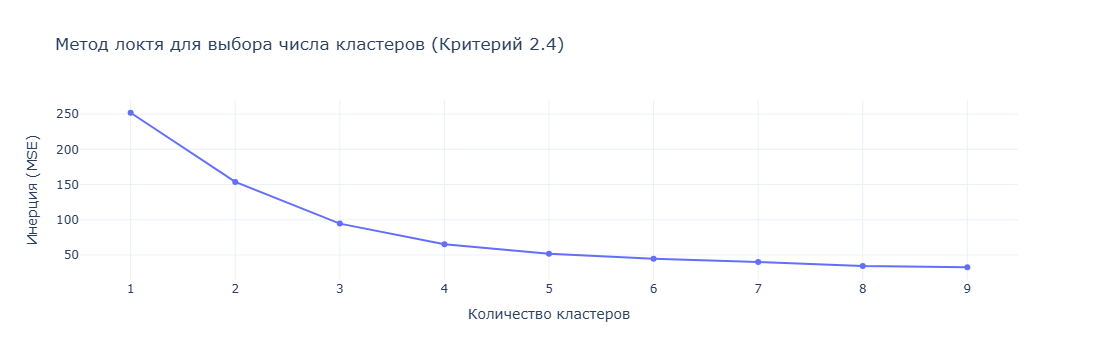

In [118]:
inertia = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(profiles_scaled)
    inertia.append(km.inertia_)

fig_elbow = px.line(x=K, y=inertia, title='Метод локтя для выбора числа кластеров (Критерий 2.4)',
                    labels={'x': 'Количество кластеров', 'y': 'Инерция (MSE)'},
                    markers=True, template="plotly_white")
fig_elbow.show()

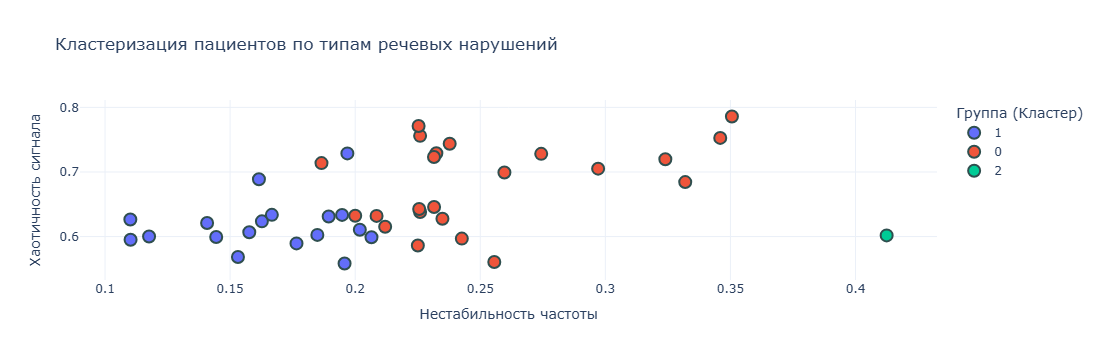

In [119]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

patient_profiles = df.groupby('subject#')[voice_checks].mean()

scaler_kmeans = StandardScaler()
profiles_scaled = scaler_kmeans.fit_transform(patient_profiles)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
patient_profiles['Cluster'] = kmeans.fit_predict(profiles_scaled)

fig_clusters = px.scatter(
    patient_profiles, 
    x='PPE', 
    y='DFA', 
    color=patient_profiles['Cluster'].astype(str),
    title="Кластеризация пациентов по типам речевых нарушений",
    labels={'color': 'Группа (Кластер)', 'PPE': 'Нестабильность частоты', 'DFA': 'Хаотичность сигнала'},
    hover_data=[patient_profiles.index],
    template="plotly_white"
)

fig_clusters.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')))
fig_clusters.show()

* Использование такой визуализации позволяет врачу мгновенно понять положение конкретного пациента относительно всей базы данных. Например, если при повторном тесте пациент переместился из синего кластера в красный — это сигнал о необходимости срочного очного осмотра, даже если сам пациент еще не жалуется на ухудшение 

##  Итоговые результаты и интерпретация
- **Точность:** Применение Random Forest на новых пациентах показало MAE ~ 0,72. Это доказывает высокую обобщающую способность модели.
- **Инсайты:** Анализ важности признаков выявил, что нелинейные показатели (DFA, PPE) важнее для диагностики, чем стандартные (Jitter).

## Ограничения (Limitations)
1. **Стадия болезни:** Модель обучена на пациентах ранней стадии (early-stage). Для работы с тяжелыми случаями требуются дополнительные данные.
2. **Тип записи:** Данные получены через специализированное устройство мониторинга. Работа на обычных смартфонах может потребовать калибровки.
3. **Персонализация:** Хотя модель хорошо предсказывает тренд, индивидуальные "провалы" в графиках показывают, что состояние пациента может зависеть от времени приема лекарств, что не учтено в данном наборе данных.